In [ ]:
!pip install mastml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of globus-compute-sdk to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of globus-compute-sdk to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of funcx to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of funcx to determine which version is compatible

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/skunkworks_data_v5 (4).csv'  # Update with your file path
df = pd.read_csv(file_path)

# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Count the number of donations per day
donation_counts = df.groupby('Date').size().reset_index(name='donation_count')

# Check if donation_counts DataFrame is correct
print(donation_counts.head())  # This should display 'Date' and 'donation_count'

# Define a helper function to get the mode for categorical columns
def mode(series):
    return series.mode()[0] if not series.mode().empty else None

# Group by 'Date' and calculate the mode for each categorical column
daily_modes = df.groupby('Date').agg({
    'Type': mode,
    'Fund': mode,
    'Campaign': mode,
    'Appeal': mode,
    'Zip': mode,
    'Quarter': mode,
    'DayOfWeek': mode,
    'Season': mode,
    'Proximity to Holiday': mode
}).reset_index()

# Merge the donation count with the daily modes DataFrame
daily_modes = pd.merge(daily_modes, donation_counts, on='Date', how='left')

# Check the merged DataFrame to ensure 'donation_count' is present
print(daily_modes.head())  # This should show 'donation_count' column

# Create 3-day rolling window sum for donations
daily_modes['5day-rolling_donations'] = daily_modes['donation_count'].rolling(window=5).sum()  # 3-day window sum of donations

# Function to apply rolling mode for categorical columns manually
def rolling_mode(series, window):
    result = []
    for i in range(len(series)):
        start = max(0, i - window + 1)  # Start of the window
        end = i + 1  # End of the window
        mode_value = series[start:end].mode()  # Get the mode of the window
        result.append(mode_value[0] if not mode_value.empty else None)  # Append mode (or None if no mode)
    return result

# Apply rolling mode for each categorical column manually
daily_modes['5day_rolling_Type'] = rolling_mode(daily_modes['Type'], 5)
daily_modes['5day_rolling_Fund'] = rolling_mode(daily_modes['Fund'], 5)
daily_modes['5day_rolling_Campaign'] = rolling_mode(daily_modes['Campaign'], 5)
daily_modes['5day_rolling_Appeal'] = rolling_mode(daily_modes['Appeal'], 5)
daily_modes['5day_rolling_Zip'] = rolling_mode(daily_modes['Zip'], 5)

# Drop rows where rolling sum is NaN (the first two rows won't have rolling sums)
daily_modes = daily_modes.dropna(subset=['5day-rolling_donations'])

# Sort by 'Date' in descending order (latest to earliest)
daily_modes = daily_modes.sort_values(by='Date', ascending=False).reset_index(drop=True)

# Save the result to a CSV file
output_file_path = '/content/drive/MyDrive/skunkworks_data_v5 (4)_with_rolling_sum.csv'  # Update with your desired output path
daily_modes.to_csv(output_file_path, index=False)

# Display the result
print(daily_modes.head())


        Date  donation_count
0 2023-01-01              46
1 2023-01-02               4
2 2023-01-03               1
3 2023-01-04               2
4 2023-01-05              26
        Date                         Type          Fund           Campaign  \
0 2023-01-01   Recurring Donation Payment  Unrestricted  Support The River   
1 2023-01-02                     Donation  Unrestricted  Support The River   
2 2023-01-03  Recurring Donation Schedule  Unrestricted  Support The River   
3 2023-01-04                     Donation  Unrestricted  Support The River   
4 2023-01-05   Recurring Donation Payment  Unrestricted  Support The River   

                     Appeal    Zip  Quarter  DayOfWeek  Season  \
0         Individual Online  53704        1          6       1   
1         Individual Online  23111        1          0       1   
2         Individual Online  53713        1          1       1   
3  Individual Multi Channel  53704        1          2       1   
4         Individual Online

In [ ]:
import os                        # OS stands for Operating System and provides ways for python to interact with files or directories
from collections import Counter  # Collections is a package for handling data
from pprint import pprint

import pandas as pd              # Pandas is a data analysis library which we'll primarily use to handle our dataset
import numpy as np               # Numpy is a package for scientific computing. We'll use it for some of it's math functions
import matplotlib                # Matplotlib is the plotting package that we'll use throughout the lab
import matplotlib.pyplot as plt
import seaborn as sns            # Seaborn is a Python data visualization library based on matplotlib
import sklearn                   # Scikit-learn is a machine learning package, providing the backbone for the work we'll perform
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate,GridSearchCV,ParameterGrid
from sklearn.model_selection import KFold,RepeatedKFold

# MastML and other imports
from mastml.mastml import Mastml
from mastml.models import SklearnModel
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector, ShapFeatureSelector
from mastml.feature_generators import OneHotGroupGenerator
from mastml.data_splitters import SklearnDataSplitter
import numpy as np
from copy import copy
import mastml
import os
try:
    data_path = os.path.join(mastml.__path__._path[0], 'data')
except:
    data_path = os.path.join(mastml.__path__[0], 'data')

In [ ]:
import pandas as pd

# Load the CSV file (replace 'your_file.csv' with your actual file path)
df = pd.read_csv('/content/drive/MyDrive/skunkworks_data_v5 (4)_with_rolling_sum.csv')

# Display the first few rows to check the data
df.head()


,Date,Type,Fund,Campaign,Appeal,Zip,Quarter,DayOfWeek,Season,Proximity to Holiday,donation_count,5day-rolling_donations,5day_rolling_Type,5day_rolling_Fund,5day_rolling_Campaign,5day_rolling_Appeal,5day_rolling_Zip
0,2024-09-25,Donation,Unrestricted,Support The River,Individual Online,53590,3,2,4,7,2,42.0,Donation,Unrestricted,Support The River,Individual Online,53716
1,2024-09-24,Donation,Unrestricted,Support The River,Individual Multi Channel,53705,3,1,4,8,5,45.0,Donation,Unrestricted,Support The River,Individual Online,53716
2,2024-09-22,Donation,Unrestricted,Support The River,Individual Online,53716,3,6,4,10,1,44.0,Donation,Unrestricted,Support The River,Individual Online,53716
3,2024-09-21,Donation,Unrestricted,Support The River,Individual Online,53716,3,5,4,11,2,45.0,Donation,Unrestricted,Support The River,Individual Online,53711
4,2024-09-20,Recurring Donation Payment,Unrestricted,Support The River,Individual Online,53704,3,4,4,12,32,86.0,Donation,Unrestricted,Support The River,Individual Multi Channel,53704


In [ ]:
# One-hot encode categorical features
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['5day_rolling_Type', '5day_rolling_Fund', '5day_rolling_Campaign', '5day_rolling_Appeal']

encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[categorical_features])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))

In [ ]:
featurized_df = pd.concat([df.drop(columns=categorical_features), one_hot_df], axis=1)
featurized_df

,Date,Type,Fund,Campaign,Appeal,Zip,Quarter,DayOfWeek,Season,Proximity to Holiday,...,5day_rolling_Campaign_2024 Match Madness,5day_rolling_Campaign_2024 Sips & Slices,5day_rolling_Campaign_Match Madness 2023,5day_rolling_Campaign_Support The River,5day_rolling_Appeal_Business Multi Channel,5day_rolling_Appeal_Faith Comm Multi Channel,5day_rolling_Appeal_Foundation Multi Channel,5day_rolling_Appeal_Individual Mailing,5day_rolling_Appeal_Individual Multi Channel,5day_rolling_Appeal_Individual Online
0,2024-09-25,Donation,Unrestricted,Support The River,Individual Online,53590,3,2,4,7,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2024-09-24,Donation,Unrestricted,Support The River,Individual Multi Channel,53705,3,1,4,8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2024-09-22,Donation,Unrestricted,Support The River,Individual Online,53716,3,6,4,10,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2024-09-21,Donation,Unrestricted,Support The River,Individual Online,53716,3,5,4,11,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2024-09-20,Recurring Donation Payment,Unrestricted,Support The River,Individual Online,53704,3,4,4,12,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2023-01-09,Donation,Unrestricted,Support The River,Business Multi Channel,53704,1,0,1,7,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
607,2023-01-08,Donation,Unrestricted,Support The River,Individual Online,53704,1,6,1,8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
608,2023-01-07,Donation,Unrestricted,Support The River,Individual Multi Channel,53704,1,5,1,9,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
609,2023-01-06,Donation,Unrestricted,Support The River,Individual Multi Channel,53705,1,4,1,10,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Separate features and target variable
X = featurized_df.drop(columns=['donation_count',"Date", "5day-rolling_donations", "Zip", "Type", "Fund", "Campaign", "Appeal"])  # Features
y = featurized_df['5day-rolling_donations']  # Target variable
X
y

,5day-rolling_donations
0,42.0
1,45.0
2,44.0
3,45.0
4,86.0
...,...
606,55.0
607,49.0
608,44.0
609,43.0


In [ ]:
SAVEPATH = '/content/drive/MyDrive/skunkworks_data_v6.2.csv'

mastml_instance = Mastml(savepath=SAVEPATH)
savepath = mastml_instance.get_savepath

In [ ]:
model_rf = SklearnModel(model='RandomForestRegressor', n_estimators=150)
models = [model_rf]


preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

baseline_tests = ["test_mean", "test_permuted"]
# Run the evaluation for both models
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']
# Set up 5-fold cross-validation
splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  baseline_test=baseline_tests,
                  verbosity=1)

Running splits: 100%|██████████| 5/5 [01:20<00:00, 16.05s/it]


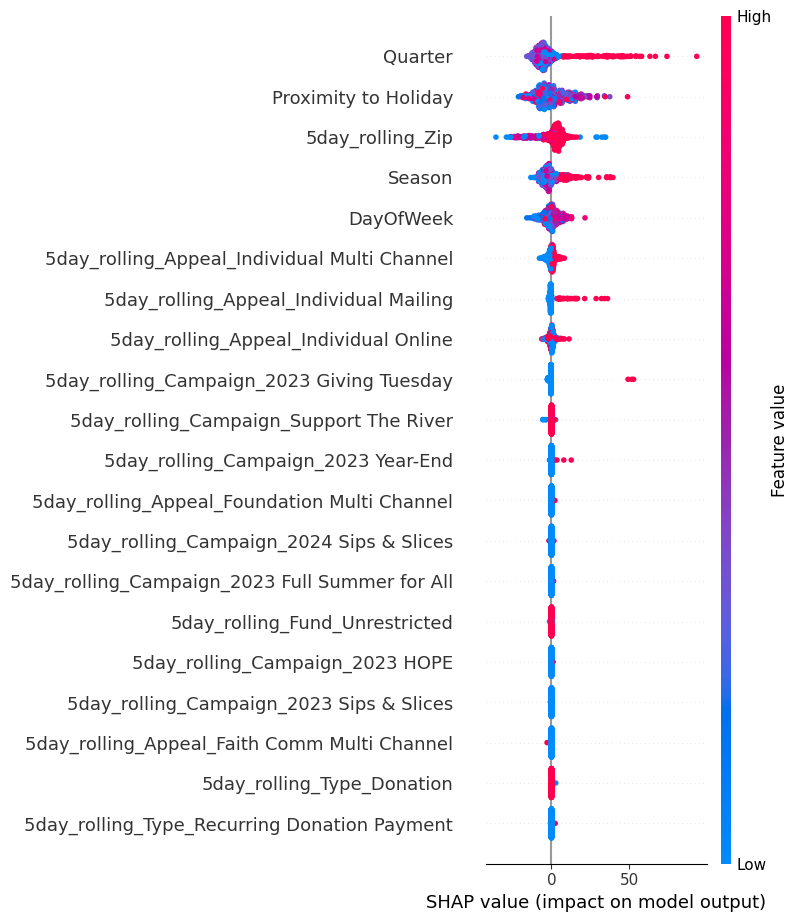

                                           Feature  Mean SHAP Value
0                                          Quarter         9.342355
3                             Proximity to Holiday         7.281662
4                                 5day_rolling_Zip         5.855353
2                                           Season         5.170627
1                                        DayOfWeek         3.421510
23    5day_rolling_Appeal_Individual Multi Channel         1.388892
22          5day_rolling_Appeal_Individual Mailing         1.295984
24           5day_rolling_Appeal_Individual Online         1.120158
11       5day_rolling_Campaign_2023 Giving Tuesday         0.817051
18         5day_rolling_Campaign_Support The River         0.191556
14             5day_rolling_Campaign_2023 Year-End         0.132854
21    5day_rolling_Appeal_Foundation Multi Channel         0.046370
16        5day_rolling_Campaign_2024 Sips & Slices         0.044915
10  5day_rolling_Campaign_2023 Full Summer for A

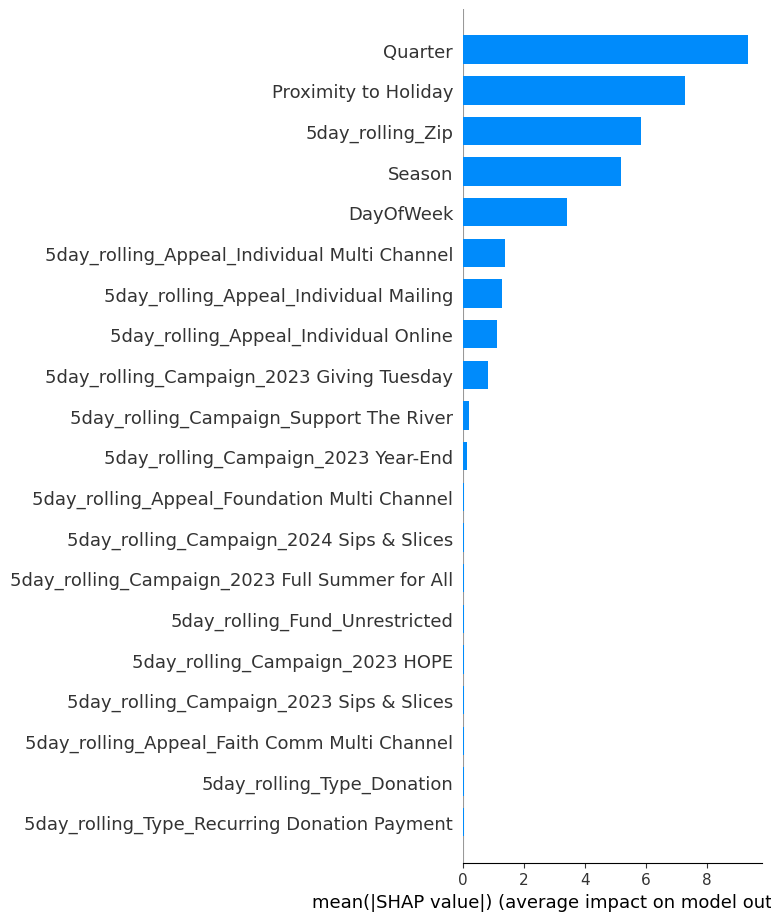

In [ ]:
# 1. Import necessary libraries
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 2. Separate features and target variable
X = featurized_df.drop(columns=['donation_count', 'Date', '5day-rolling_donations', 'Zip', 'Type', 'Fund', 'Campaign', 'Appeal'])  # Features
y = featurized_df['5day-rolling_donations']  # Target variable


model_rf.fit(X, y)

# 4. Create SHAP explainer for the trained Random Forest model
explainer = shap.TreeExplainer(model_rf)

# 5. Calculate SHAP values for the features
shap_values = explainer.shap_values(X)

# 6. SHAP Summary Plot: This shows the feature importance based on SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X)  # Summary plot based on all the instances

# 7. SHAP Force Plot for Multiple Instances
# Use this plot for a subset of predictions, e.g., first 3 instances
shap.initjs()  # Initialize JavaScript for interactive visualization
for i in range(3):  # Plotting force plots for first 3 instances
    shap.force_plot(explainer.expected_value, shap_values[i], X.iloc[i])



# 9. Calculate and display Feature Importance based on SHAP values
# For regression, calculate the mean absolute SHAP values for each feature
shap_summary = pd.DataFrame({
    'Feature': X.columns,
    'Mean SHAP Value': np.mean(np.abs(shap_values), axis=0)
})

# Sort by mean SHAP value to get feature importance
shap_summary = shap_summary.sort_values(by='Mean SHAP Value', ascending=False)

# Print the feature importance
print(shap_summary)

# 10. Optional: Plot the Feature Importance from SHAP values (Bar plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, plot_type="bar")
